# Queries, Boundaries, and H3 geometry to hexagons
## Livable streets App

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import overpy 

#query
from shapely.geometry import mapping
import requests

#creating geometry (city boundaries)
from shapely.ops import linemerge, unary_union, polygonize

#geojson
import os 
from geojson import Point, Feature, FeatureCollection, dump

#plotting in folium
import geopandas as gpd
import folium

#working with h3
import h3
from shapely.geometry import Polygon, LineString, MultiPolygon, Point
import pandas as pd

#turning off shapely warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings('ignore', category=ShapelyDeprecationWarning)

#plotting with keplerGL
import keplergl as kp

#workingdir
working_dir = os.getcwd()

import re





## Examples of paramater for queries

In [11]:
water = {'natural': ['water', 'beach'], 'amenity': ['fountain']}

cycle = {'highway': ['pedestrian', 'cycleway']}

green = {
    'landuse': [
        'grass', 'forest', 'orchard', 'allotments', 'cementery', 'flowerbed',
        'meadow', 'greenfield', 'recreation_ground', 'village_green'
    ],
    'leisure': ['park', 'playground', 'garden'],
    'natural': ['heath', 'shrubbery', 'wood', 'grassland']
}


## Example Query

In [4]:
query = f"""/*
    This has been generated by the overpass-turbo wizard.
    The original search was:
    “park in Kreuzberg”
    */
        [out:json][timeout:25];
    // fetch area “Kreuzberg” to search in
        area[name="kreuzberg"]->.searchArea;
    //{{geocodeArea:kreuzberg}}->.searchArea;
    // gather results
        (
    // query part for: “park”
    // node["leisure"="park"](area.searchArea);
        way["leisure"="park"](area.searchArea);
        relation["leisure"="park"](area.searchArea);
        );
    // print results
        out body;
        >;
        out skel qt;"""

In [5]:
query = f"""[out:json][timeout:25];
area(id:3600055765)->.searchArea;
(node["leisure"="park"](area.searchArea);
way["leisure"="park"](area.searchArea);
relation["leisure"="park"](area.searchArea);
);
out geom;
>;
out skel qt;"""

## Formated query

In [5]:
format_query = query.replace('\n','').strip()
print(format_query)

[out:json][timeout:25];area(id:3600055765)->.searchArea;(node["leisure"="park"](area.searchArea);way["leisure"="park"](area.searchArea);relation["leisure"="park"](area.searchArea););out geom;>;out skel qt;


In [7]:
response = requests.get(overpass_url, 
                            params={'data': format_query})
res = response.json()

NameError: name 'overpass_url' is not defined

In [233]:
res['elements'][6]['tags']

{'image': 'https://commons.wikimedia.org/wiki/File:Hohenstaufenplatz-Berlin-Kreuzberg-02-2017.jpg',
 'leisure': 'park',
 'name': 'Hohenstaufenplatz',
 'name:etymology:wikidata': 'Q650474',
 'name:etymology:wikipedia': 'de:Burg Hohenstaufen',
 'reg_name': 'Zickenplatz',
 'wikidata': 'Q95114181',
 'wikimedia_commons': 'Category:Hohenstaufenplatz (Berlin-Kreuzberg)',
 'wikipedia': 'de:Hohenstaufenplatz'}

In [6]:
api = overpy.Overpass()
result = api.query(query)

# Printing no. of pubs in nodes and ways
print("Amenities in nodes: %d" % len(result.nodes))
print("Amenities in ways: %d" % len(result.ways))
print("Amenities in areas: %d" % len(result.areas))

Amenities in nodes: 2856
Amenities in ways: 89
Amenities in areas: 0


In [7]:
result.ways[0].nodes[0]

<overpy.Node id=29209071 lat=52.5032558 lon=13.3773207>

In [8]:
result.ways[5].tags.get('name','')

''

## Creating geoDataFrame from polygons

In [11]:
lss = []  #convert ways to linstrings

for ii_w, way in enumerate(result.ways):
    ls_coords = []

    for node in way.nodes:
        ls_coords.append(
            (node.lon, node.lat))  # create a list of node coordinates

    lss.append(
        LineString(ls_coords))  # create a LineString from coords

merged = linemerge([*lss])  # merge LineStrings
borders = unary_union(merged)  # linestrings to a MultiLineString
polygons = list(polygonize(borders))
# parks = MultiPolygon(polygons)

parks_gdf = gpd.GeoDataFrame({'geometry': polygons},crs="EPSG:4326")

In [12]:
parks_gdf

,geometry
0,"POLYGON ((13.36862 52.49674, 13.36860 52.49651..."
1,"POLYGON ((13.36862 52.49674, 13.36863 52.49678..."
2,"POLYGON ((13.37580 52.49527, 13.37622 52.49581..."
3,"POLYGON ((13.37732 52.50326, 13.37740 52.50322..."
4,"POLYGON ((13.37867 52.49994, 13.37892 52.50016..."
...,...
84,"POLYGON ((13.44407 52.49373, 13.44424 52.49369..."
85,"POLYGON ((13.44457 52.49410, 13.44488 52.49434..."
86,"POLYGON ((13.44624 52.49527, 13.44665 52.49507..."
87,"POLYGON ((13.44752 52.49515, 13.44769 52.49528..."


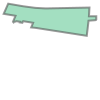

In [13]:
parks_gdf.iloc[0][0]

https://github.com/nikhilnagargit/OpenStreetMapDataExtraction/blob/master/data_task__by_nikhil.py

In [7]:
polygon = []

for way in result.ways:
    polygon.append(Polygon(LineString([(node.lon, node.lat) for node in way.nodes])))
polygon


In [13]:
lss = []  #convert ways to linstrings
polygon = []

for way in result.ways:
    lss.append({'geometry' : [Polygon(LineString([(node.lon, node.lat) for node in way.nodes])).wkt],
                'name': [way.tags.get('name','')]})
    
lss[2]

{'geometry': ['POLYGON ((13.3786728 52.4999418, 13.3789191 52.5001621, 13.3790405 52.5002182, 13.3791066 52.5003033, 13.3794789 52.5008722, 13.3794946 52.500899, 13.3795251 52.5011913, 13.3795278 52.5012516, 13.3794992 52.5012826, 13.3795374 52.5013101, 13.3794486 52.5014423, 13.3796143 52.5016508, 13.3796939 52.5016347, 13.3799929 52.5020329, 13.3800337 52.5021021, 13.3801855 52.5020611, 13.3802706 52.5021803, 13.3803828 52.5021889, 13.3805466 52.5021484, 13.3814852 52.5034689, 13.3812687 52.5035259, 13.3808041 52.5036488, 13.3815307 52.5039906, 13.3816303 52.5039132, 13.3816469 52.5039003, 13.3816943 52.5038622, 13.3817209 52.5038466, 13.3819226 52.5037916, 13.3819789 52.503777, 13.3822119 52.5037166, 13.3826323 52.5036082, 13.3827342 52.5035819, 13.3827583 52.5035757, 13.3827813 52.5035697, 13.3832624 52.5034416, 13.3831135 52.5032271, 13.3822094 52.502058, 13.3809806 52.5023636, 13.3802264 52.5013527, 13.3815138 52.5009884, 13.3803555 52.4993643, 13.3798089 52.4994588, 13.379766 52

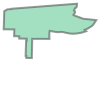

In [30]:
def nodes_to_polygons(result):
    poly_list = []
    for way in result.ways:
        poly_list.append(Polygon(LineString([(node.lon, node.lat) for node in way.nodes])))
    return poly_list

def get_tags(result):
    tags = []
    for way in result.ways:
        tags.append(way.tags.get('name',''))
    return tags

features_gdf = gpd.GeoDataFrame({'geometry': nodes_to_polygons(result), 'name': get_tags(result)},crs="EPSG:4326", geometry='geometry')    
features_gdf.geometry[1]


# list(map(nodes_to_polygon, [*result.ways[0].nodes]))
# list(itertools.chain(*[list(itertools.product([k], v)) for way in result.ways]))

In [8]:
geometry = pd.Series(polygon)
geometry

0     POLYGON ((13.3773207 52.5032558, 13.3769375 52...
1     POLYGON ((13.3807694 52.4867775, 13.3806709 52...
2     POLYGON ((13.3786728 52.4999418, 13.3789191 52...
3     POLYGON ((13.3816014 52.5006683, 13.3821186 52...
4     POLYGON ((13.432068 52.4991676, 13.4337931 52....
                            ...                        
84    POLYGON ((13.4150959 52.5017858, 13.4151019 52...
85    POLYGON ((13.4223215 52.5028747, 13.4223616 52...
86    POLYGON ((13.4445653 52.4940977, 13.444678 52....
87    POLYGON ((13.4507249 52.4967779, 13.4506139 52...
88    POLYGON ((13.4221178 52.5046766, 13.4221952 52...
Length: 89, dtype: object

### saving geojson multipolygon

In [18]:

# with open(f'{working_dir}/data/{city_name}_parks.geojson', 'w') as f:
#     dump(mapping(parks), f)

with open(f'{working_dir}/data/{city_name}_parks.geojson', 'w') as f:
    dump(parks_gdf, f)

In [14]:
parks_gdf_read = gpd.read_file(f'{working_dir}/data/{city_name}_parks.geojson')
parks_gdf_read

,id,geometry
0,0,"POLYGON ((13.36862 52.49674, 13.36860 52.49651..."
1,1,"POLYGON ((13.36862 52.49674, 13.36863 52.49678..."
2,2,"POLYGON ((13.37580 52.49527, 13.37622 52.49581..."
3,3,"POLYGON ((13.37732 52.50326, 13.37740 52.50322..."
4,4,"POLYGON ((13.37867 52.49994, 13.37892 52.50016..."
...,...,...
84,84,"POLYGON ((13.44407 52.49373, 13.44424 52.49369..."
85,85,"POLYGON ((13.44457 52.49410, 13.44488 52.49434..."
86,86,"POLYGON ((13.44624 52.49527, 13.44665 52.49507..."
87,87,"POLYGON ((13.44752 52.49515, 13.44769 52.49528..."


## plotting on folium

In [21]:
map_test = folium.Map(width=750,
                      height=500,
                      location=[
                          res['elements'][0]['bounds']['maxlat'],
                          res['elements'][0]['bounds']['maxlon']
                      ],
                      tiles="openstreetmap",
                      zoom_start=15)
folium.GeoJson(parks_gdf).add_to(map_test)

In [22]:
map_test

<AxesSubplot: >

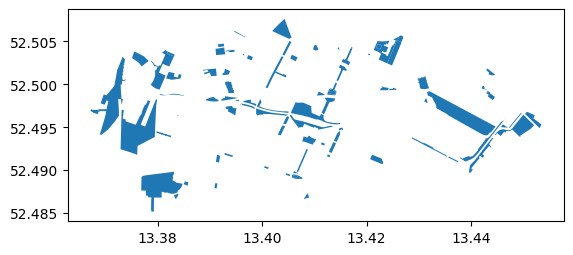

In [15]:
parks_gdf_read.plot()

# Hexagons H3

In [16]:
parks_gdf_read.columns

Index(['id', 'geometry'], dtype='object')

In [102]:
res = 11

## geometry to H3 indexes (polyfill)

In [103]:
parks_gdf_h3 = parks_gdf_read.copy()
parks_gdf_h3['h3_index'] = parks_gdf_h3['geometry'].apply(
    lambda polys: h3.polyfill(mapping(polys), res, geo_json_conformant=True)
    if bool(h3.polyfill(mapping(polys), res)) 
    else {h3.geo_to_h3(polys.centroid.y, polys.centroid.x, res)})
parks_gdf_h3.set_index('id', inplace=True)
parks_gdf_h3

,geometry,h3_index
id,,
0,"POLYGON ((13.36862 52.49674, 13.36860 52.49651...","{8b1f18b249a2fff, 8b1f18b249a3fff}"
1,"POLYGON ((13.36862 52.49674, 13.36863 52.49678...","{8b1f1d48a252fff, 8b1f18b24822fff, 8b1f18b2491..."
2,"POLYGON ((13.37580 52.49527, 13.37622 52.49581...","{8b1f18b2412bfff, 8b1f18b248d9fff, 8b1f18b248c..."
3,"POLYGON ((13.37732 52.50326, 13.37740 52.50322...","{8b1f1d48b5a4fff, 8b1f1d48b5a6fff, 8b1f1d48a24..."
4,"POLYGON ((13.37867 52.49994, 13.37892 52.50016...","{8b1f1d48b4a6fff, 8b1f1d48b4a0fff, 8b1f1d48b42..."
...,...,...
84,"POLYGON ((13.44407 52.49373, 13.44424 52.49369...","{8b1f1d4d2543fff, 8b1f1d4d2541fff, 8b1f1d4d255..."
85,"POLYGON ((13.44457 52.49410, 13.44488 52.49434...","{8b1f1d4d2153fff, 8b1f1d4d2020fff, 8b1f1d4d207..."
86,"POLYGON ((13.44624 52.49527, 13.44665 52.49507...",{8b1f1d4d2025fff}


In [104]:
type(parks_gdf_h3['geometry'][0])

shapely.geometry.polygon.Polygon

## Converting shapely.polygon to geojson

In [105]:
gpd.GeoSeries(parks_gdf_h3['geometry'][0]).__geo_interface__
mapping(parks_gdf_h3['geometry'])

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': (((13.3686239, 52.4967435),
      (13.3685962, 52.4965108),
      (13.3685273, 52.4965215),
      (13.368321, 52.4965535),
      (13.368236, 52.4965667),
      (13.3679043, 52.4966182),
      (13.3676957, 52.4966505),
      (13.3676215, 52.4966576),
      (13.3676558, 52.4967391),
      (13.367481, 52.496767),
      (13.3674672, 52.496739),
      (13.3674233, 52.4967452),
      (13.3674277, 52.4967576),
      (13.3673616, 52.4967668),
      (13.3673455, 52.4967596),
      (13.3673291, 52.4967607),
      (13.367314, 52.4967449),
      (13.3673029, 52.4967574),
      (13.3673472, 52.4968617),
      (13.3671398, 52.4968961),
      (13.3672184, 52.4970737),
      (13.3674892, 52.4970275),
      (13.3676926, 52.4970009),
      (13.3678735, 52.4969908),
      (13.3686435, 52.4970062),
      (13.3686362, 52.496877),
      (13.368634, 52.49685

In [106]:
parks_gdf_h3['h3_index'][1]

{'8b1f18b24806fff',
 '8b1f18b24814fff',
 '8b1f18b24815fff',
 '8b1f18b24816fff',
 '8b1f18b24822fff',
 '8b1f18b24824fff',
 '8b1f18b24825fff',
 '8b1f18b24826fff',
 '8b1f18b24830fff',
 '8b1f18b24831fff',
 '8b1f18b24832fff',
 '8b1f18b24833fff',
 '8b1f18b24834fff',
 '8b1f18b24835fff',
 '8b1f18b24836fff',
 '8b1f18b248a0fff',
 '8b1f18b248a4fff',
 '8b1f18b248a5fff',
 '8b1f18b248a6fff',
 '8b1f18b248b5fff',
 '8b1f18b24900fff',
 '8b1f18b24901fff',
 '8b1f18b24902fff',
 '8b1f18b24903fff',
 '8b1f18b24905fff',
 '8b1f18b24906fff',
 '8b1f18b24908fff',
 '8b1f18b2490afff',
 '8b1f18b2490cfff',
 '8b1f18b2490dfff',
 '8b1f18b2490efff',
 '8b1f18b24911fff',
 '8b1f18b24915fff',
 '8b1f18b24918fff',
 '8b1f18b24919fff',
 '8b1f18b2491afff',
 '8b1f18b2491bfff',
 '8b1f18b2491cfff',
 '8b1f18b2491dfff',
 '8b1f18b24928fff',
 '8b1f18b24929fff',
 '8b1f18b2492afff',
 '8b1f18b2492bfff',
 '8b1f18b2492dfff',
 '8b1f18b24988fff',
 '8b1f18b24989fff',
 '8b1f18b2498afff',
 '8b1f18b2498bfff',
 '8b1f18b2498dfff',
 '8b1f18b249a8fff',


## Exploding list of H3 indexes to hex_ids

In [107]:
parks_gdf_h3explode = parks_gdf_h3.explode('h3_index')
parks_gdf_h3explode = parks_gdf_h3explode.rename(columns={'h3_index' : 'hex_id'})
parks_gdf_h3explode

,geometry,hex_id
id,,
0,"POLYGON ((13.36862 52.49674, 13.36860 52.49651...",8b1f18b249a2fff
0,"POLYGON ((13.36862 52.49674, 13.36860 52.49651...",8b1f18b249a3fff
1,"POLYGON ((13.36862 52.49674, 13.36863 52.49678...",8b1f1d48a252fff
1,"POLYGON ((13.36862 52.49674, 13.36863 52.49678...",8b1f18b24822fff
1,"POLYGON ((13.36862 52.49674, 13.36863 52.49678...",8b1f18b2491bfff
...,...,...
88,"POLYGON ((13.45072 52.49678, 13.45157 52.49655...",8b1f1d4d2149fff
88,"POLYGON ((13.45072 52.49678, 13.45157 52.49655...",8b1f1d4d216bfff
88,"POLYGON ((13.45072 52.49678, 13.45157 52.49655...",8b1f1d4d214dfff


In [108]:
h3_count = parks_gdf_h3explode.groupby('hex_id').count().sort_values(by='geometry', ascending=False)

## Testing individual geometry

In [109]:
poly = [
    geometry.Polygon(h3.h3_to_geo_boundary(x, geo_json=True))
    for x in parks_gdf_h3['h3_index'][1]
]


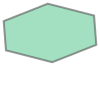

In [110]:
poly[1]

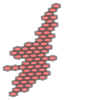

In [111]:
geometry.MultiPolygon(poly)

## hex_ids to Hexagon(Polygons)

In [112]:
# parks_gdf_h3['h3_poly'] = parks_gdf_h3['h3_index'].apply(lambda h3_polygon: 
#     geometry.MultiPolygon(
#     geometry.Polygon(h3.h3_to_geo_boundary(h3_cell, geo_json=True))
#     for h3_cell in h3_polygon
#     )
# )


parks_gdf_h3explode.dropna(inplace=True)
parks_gdf_h3explode['geometry'] = parks_gdf_h3explode['hex_id'].apply(lambda h3_polygon: 
    geometry.Polygon(h3.h3_to_geo_boundary(h3_polygon, geo_json=True))
)
parks_gdf_h3explode

,geometry,hex_id
id,,
0,"POLYGON ((13.36702 52.49689, 13.36704 52.49665...",8b1f18b249a2fff
0,"POLYGON ((13.36774 52.49693, 13.36776 52.49670...",8b1f18b249a3fff
1,"POLYGON ((13.37309 52.50289, 13.37311 52.50266...",8b1f1d48a252fff
1,"POLYGON ((13.37207 52.49720, 13.37209 52.49696...",8b1f18b24822fff
1,"POLYGON ((13.37096 52.49748, 13.37098 52.49725...",8b1f18b2491bfff
...,...,...
88,"POLYGON ((13.45158 52.49605, 13.45160 52.49581...",8b1f1d4d2149fff
88,"POLYGON ((13.45080 52.49670, 13.45082 52.49647...",8b1f1d4d216bfff
88,"POLYGON ((13.45119 52.49638, 13.45121 52.49614...",8b1f1d4d214dfff


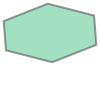

In [113]:
parks_gdf_h3explode['geometry'][0]

## polygons to string wkt

In [114]:
h3_str = pd.DataFrame(parks_gdf_h3['geometry'].map(lambda x: x.wkt))
h3_str

,geometry
id,
0,"POLYGON ((13.3686239 52.4967435, 13.3685962 52..."
1,"POLYGON ((13.3686239 52.4967435, 13.3686269 52..."
2,"POLYGON ((13.375802 52.4952652, 13.3762169 52...."
3,"POLYGON ((13.3773207 52.5032558, 13.3773982 52..."
4,"POLYGON ((13.3786728 52.4999418, 13.3789191 52..."
...,...
84,"POLYGON ((13.4440677 52.4937294, 13.444236 52...."
85,"POLYGON ((13.4445653 52.4940977, 13.4448828 52..."
86,"POLYGON ((13.4462441 52.4952663, 13.4466458 52..."


In [120]:
h3_str['geometry'][0]

'POLYGON ((13.3686239 52.4967435, 13.3685962 52.4965108, 13.3685273 52.4965215, 13.368321 52.4965535, 13.368236 52.4965667, 13.3679043 52.4966182, 13.3676957 52.4966505, 13.3676215 52.4966576, 13.3676558 52.4967391, 13.367481 52.496767, 13.3674672 52.496739, 13.3674233 52.4967452, 13.3674277 52.4967576, 13.3673616 52.4967668, 13.3673455 52.4967596, 13.3673291 52.4967607, 13.367314 52.4967449, 13.3673029 52.4967574, 13.3673472 52.4968617, 13.3671398 52.4968961, 13.3672184 52.4970737, 13.3674892 52.4970275, 13.3676926 52.4970009, 13.3678735 52.4969908, 13.3686435 52.4970062, 13.3686362 52.496877, 13.368634 52.4968527, 13.3687627 52.4968539, 13.3687634 52.4967976, 13.3687587 52.4967894, 13.368746 52.4967845, 13.3686269 52.4967761, 13.3686239 52.4967435))'

# KeplerGL

## keplerGL h3 layer (not working)
To use H3 layer, you need a hex_id or hexagon_id in your dataset, which can be generated using h3-js from latitude, longitude and resolution.

Naming Convention
kepler.gl auto generates H3 layer from column: hex_id, hexagon_id

Sample dataset:
hex_id | value | 
|----------|:------:|
 89283082c2fffff | 64 | 
 8928308288fffff | 73 | 
 89283082c07ffff | 65 | 


## Keplergl map with polygon geometry

In [121]:
map_1 = kp.KeplerGl()
map_1.add_data(data = parks_gdf_h3explode[['geometry']], name='h3')
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'h3': {'index': ['0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'…

## saving h3 cells

In [1]:
parks_gdf_h3explode.to_file(f'{working_dir}/data/{city_name}_parks.gpkg', driver='GPKG', layer='name')  


NameError: name 'parks_gdf_h3explode' is not defined